# <center>Projet traitement de données
Notre étude s'inscrit dans le cadre d'une réponse à l'appel de l'ADEME avec pour but de générer une tournée de livraison sur plusieurs villes de manière optimisée en utilisant l'algorithme des colonies de fourmis en considérant une contrainte de fenetre de livraison.

# <font color="blue">Partie 1 : Génération des données</font>   

## 1.Génération d'une matrice pondérée aléatoire

Nous commençons par générer une matrice de graphe pondéré aléatoire

In [1]:
import numpy as np
import json
import os

plage_horaire = {'3h-9h': 85/100, '9h-15h': -25/100, '15h-21h': 30/100,'21h-3h':-50/100} #Tableau avec nos prévisions de trafics
taille_max = 10
valeur_max = 15
delivery_window_start = 8

In [2]:
import numpy as np
import json
import os
def grapheAleatoire(taille_max, valeur_max):
    data= []
    
    b = np.random.choice((0,1), size=(taille_max,taille_max), p=[0.0, 1.0]) #Génération d'une matrice binaire
    b_symm = np.logical_or(b, b.T) 
    matrice =  b_symm.astype(int) #Rendre la matrice non orienté
    
    #Récupération des graphes présents dans le fichier
    fileName = r"graph.json"
    if os.path.isfile(fileName):
        with open('graph.json', 'r') as fp:
            data = json.load(fp)
    #Ajout des poids dans la matrice de manière aléatoire
    for ligne in range(taille_max):
        if (matrice[ligne][ligne]):
            matrice[ligne][ligne] = 0
        for sommet in range(taille_max):            
            if (matrice[ligne][sommet] == 1):
                poids = np.random.randint(1,valeur_max)
                matrice[ligne][sommet] = poids
                matrice[sommet][ligne] = matrice[ligne][sommet]
    data.append(matrice.tolist())
    #Remplissage du fichier avec le nouveau graphe
    with open('graph.json', 'w') as fp:
        json.dump(data, fp)
    return matrice

___grapheAleatoire___ permet de générer un graphe pondéré aléatoire. Cette fonction utilise deux paramètres : <br>
- __taille_max__ : correspond au nombre de sommet du graphe
- __valeur_max__ : correspond au poids maximum d'une arête <br><br>

Pour y parvenir, nous avons différentes étapes : <br>
- Un point ne peux pas avoir une arête vers lui-même
- Lorsque l'on modifie une arête, nous modifions, dans le tableau, l'autre instance de cette arête


## 2.Ajout de poids en fonction de la fenètre de livraison

In [3]:
def matrice_prevision(matrice, delivery_window_start, plage_horaire):
    matrice_cur = matrice.copy()
    for ligne in range(len(matrice_cur)):
        for sommet in range(len(matrice_cur)):
            poids = matrice_cur[ligne][sommet]
            if (delivery_window_start < 3 or delivery_window_start >= 21):
                poids += plage_horaire['21h-3h'] * poids
            elif (delivery_window_start >= 3 and delivery_window_start < 9):
                poids += plage_horaire['3h-9h'] * poids
            elif (delivery_window_start >= 9 and delivery_window_start < 15):
                poids += plage_horaire['9h-15h'] * poids
            elif (delivery_window_start >= 15 and delivery_window_start < 21):
                poids += plage_horaire['15h-21h'] * poids
            matrice_cur[ligne][sommet] = poids
    return matrice_cur

___matrice_prevision___ permet de modifier les poids des arêtes en fonction de la fenêtre de livraison choisie. Cette fonction utilise trois paramètres : <br>
- __matrice__ : correspond à notre graphe
- __delivery_window_start__ : correspond au début de la fenêtre de livraison
- __plage_horaire__ : correspond au tableau de valeurs des différentes plages horaires<br><br>

Pour y parvenir, nous avons différentes étapes : <br>
- Nous faisons une copie de la matrice
- Nous faisons une série de conditions pour faire la bonne modification de poids


## 3.Exemple d'application

In [4]:
matrice = grapheAleatoire(taille_max, valeur_max)

matrice_cur = matrice_prevision(matrice, delivery_window_start, plage_horaire)
print("Matrice_cur", matrice_cur)
print("Matrice", matrice)

Matrice_cur [[ 0  9 25 12  9 16 18 20  7 18]
 [ 9  0  7 14  7 22 22  5 11  3]
 [25  7  0  9 14  7  5  5  3  7]
 [12 14  9  0 14 22 20 20 16  3]
 [ 9  7 14 14  0  3  7 24 18 16]
 [16 22  7 22  3  0 16 20 14 25]
 [18 22  5 20  7 16  0 14 22 24]
 [20  5  5 20 24 20 14  0 16 25]
 [ 7 11  3 16 18 14 22 16  0 18]
 [18  3  7  3 16 25 24 25 18  0]]
Matrice [[ 0  5 14  7  5  9 10 11  4 10]
 [ 5  0  4  8  4 12 12  3  6  2]
 [14  4  0  5  8  4  3  3  2  4]
 [ 7  8  5  0  8 12 11 11  9  2]
 [ 5  4  8  8  0  2  4 13 10  9]
 [ 9 12  4 12  2  0  9 11  8 14]
 [10 12  3 11  4  9  0  8 12 13]
 [11  3  3 11 13 11  8  0  9 14]
 [ 4  6  2  9 10  8 12  9  0 10]
 [10  2  4  2  9 14 13 14 10  0]]


# <font color="blue">Partie 2 : Modélisation du problème</font>

## 1.Définition du problème formel
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Données

Notre problème comporte plusieurs données :
<ul>
    <li>Un graphe complet pondéré G ==> chaque arête à un poids correspondant au nombre de véhicules circulant sur cette arête et pouvant varié selon l'heure de la journée</li>
    <li>Plusieurs sommets ==> ici, chaque sommet correspond à un sous-ensemble de villes</li>
    <li>Un cycle ==> effectuer une tournée de livraison en partant d'un point et en revenant à ce même point</li>
    <li>Fenêtres de temps de livraison ==> les livraisons devront être effectuées dans une plage horaire définis</li>
</ul>

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Question 

Existe-t-il un cycle passant au moins une fois par chaque sommet de G qui respecte les fenêtres de temps de livraison et dont la somme des valeurs des arêtes est au plus égale à k ?

## 2.Etude de complexité de ce problème

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Notre problème est-il dans NP ?
Grâce à l'instance de notre problème, on peut déterminer si oui ou non notre problème est dans NP.
Nous pouvons vérifier l'instance de notre problème en temps polynomial car pour un cycle, on peut déterminer si:
    
<ul>
    <li>Il s'agit bien d'un cycle ==> vérifier que la première et la dernière valeur sont le même sommet</li>
    <li>Le cycle passe bien par tous les sommets ==> parcourir le tableau en s'assurant que tous les sommets sont bien présents</li>
    <li>Son coût est inférieur à k ==> comparer le poids du chemin obtenu avec k</li>
</ul>

Notre problème est donc dans NP.
    
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Est-il NP Complet ou non ?

Notre instance de problème I est une instance red(I) du problème du voyageur de commerce (TSP) car le voyageur de commerce consiste à chercher un cycle hamiltonien de plus petit poids dans un graphe pondéré complet. Généralement, le poids correspond à la distance de l'arête mais il est possible d'adapter cette représentation à notre cas de figure.
    
*Cycle hamiltonien : chemin qui passe au moins une fois par chacun des sommets en revenant à son point de départ.*
<br>*Graphe complet : graphe simple dont tous les sommets sont adjacents deux à deux, c'est-à-dire que tout couple de sommets disjoints est relié par une arête*
![graphe](https://i1.wp.com/www.methodemaths.fr/graphe_complet.jpg?w=584&ssl=1)
Réduction polynomiale :
    <ul>
        <li>Notre instance I (G = (S,A),k) et l'instance TSP red(I) (G' = (S,A'),k) ==> Pour tout (G,k), I(G,k) si et seulement si red(I)(G',k) ?</li> Si (G = (S, A), k) a un chemin C de poids inférieur à k, C est un chemin de poids inférieur à k de G'. <br>Réciproquement: si (G' = (S, A' ), k) a un chemin C de poids inférieur à k, C est un chemin de poids inférieur à k de G.<br><br>
    <li>La transformation est polynomiale: l’algorithme qui calcule red(I) est bien polynomial : sa complexité est de n²2^n ( voir <a href="http://algorithmics.lsi.upc.edu/docs/Dasgupta-Papadimitriou-Vazirani.pdf">Algorithms</a>
, p179)</li><br>
On peut donc dire que notre problème est au moins aussi difficile que le problème du voyageur de commerce, soit notre problème Pb >= TSP. 
Cependant, on sait que le problème TSP est NP difficile et notre problème Pb est dans NP, donc d'après le schéma ci-dessous, notre problème est NP Complet.

<img src="https://4.bp.blogspot.com/-gxblHm308a8/XI-3wxvpWUI/AAAAAAAADKc/4u5HTH2SLkcoj1oiyPW8bUuMEjCPOQNKwCLcBGAs/s1600/Diff%25C3%25A9rence%2Bentre%2Bun%2Bprobl%25C3%25A8me%2BNP-Complet%2Bet%2BNP-Difficile-1.png" alt="drawing"/>

# <font color="blue">Partie 3 : Modélisation de l'algorithme</font>

<p>Le problème algorithmique consiste donc à calculer un itinéraire sur un réseau routier permettant de relier un sous-ensemble de villes entre elles, puis de revenir à son point de départ, afin de minimiser la durée totale de la tournée. Cette optimisation devra tenir compte du trafic prévu sur chaque axe pour les différents créneaux horaires.</p>


## 1.Modélisation linéaire

<p>Nous fourmulons le TSP que nous presentons ici sous formes mathematique utilisée en programmation linéaire en nombre entiers. Elle traduit la modélisation naturelle du problème par la définition de variable, noté (i,j)</p>

<blockquote>

### Variables de décision
<br />
     $c_(ij)$ est le coût de l'arête allant de i à j. <br /><br />
     $x_(ij) = $$\begin{pmatrix} 1 & Si&j&est&visité&apres&i \\ 0 & Sinon \end{pmatrix}$$ $<br /><br />
     $x_(ij) = 1$ si la tournée va du sommet $i$ au sommet $j$, sinon $x_(ij) = 0$. Le tour doit avoir exactement une arête sortant du sommet $i$ (degré de sortie = 1) et une arête entrant dans le sommet $i$ (degré d'entrée = 1). Cela s'explique par le fait qu'un tour est un cycle.<br /><br />


 $u(i)$ et $u(j)$ sont des variables fictives pour lesquelles nous devons résoudre.<br /><br />
    
### Contraintes du programme
* Contrainte 1 : Besoins d'avoir que chaque ville ait exactement un successeur dans la tournée : $\displaystyle\sum_{ j | (i,j) \in[A]}{X(ij)} = 1 $
<br /><br />

* Contrainte 2 : Besoins d'avoir exactement un prédécesseur pour chaque noeud :$\displaystyle\sum_{ i | (i,j) \in[A]}{X(ij)} = 1$
<br /><br />
    
* Contrainte 3 : Élimination des sous-tours :     $u(i)$-$u(j)$&nbsp; + &nbsp; $ $n$x_(ij)$$\leq$n$ $ &nbsp; - &nbsp; $1$
<br /><br />
    
### Objectif fonction
<br />
   <p>Nous voulons minimiser la somme des connections entre les villes du cout entre $i$ à $j$. Puisque nous avons une fonction linéaire que nous souhaitons optimiser et un ensemble de contraintes, nous pouvons appliquer la méthode du simplexe pour résoudre cette forme de programme linéaire.</p>

<br />

### Programme linéaire
<br />
    $\text{Minimiser  $z$ = } \displaystyle{n}\sum_{i=1}\displaystyle{n}\sum_{j=1}{C(ij)}X(ij) $
<br /><br />
    $\text{sc to}$ &nbsp; $\displaystyle{n}\sum_{j=i}{X(ij)} = 1$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $1\leq(i)\leq(n)$ &nbsp;&nbsp;&nbsp;$ ∀(i)\in(I) $
<br /><br />
    $\displaystyle{n}\sum_{i=j}{X(ij)} = 1$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $1\leq(j)\leq(n)$ &nbsp;&nbsp;&nbsp;$ ∀(i)\in(J) $
<br /><br />
    $u(i)$-$u(j)$&nbsp; + &nbsp; $ $n$x_(ij)$$\leq$n$ $ &nbsp; - &nbsp; $1$


</blockquote><br />

## 2.Modelisation de l'algorithme : Algorithme de colonies de fourmis

### Pourquoi utiliser l'algorithme des colonies de fourmis ?

<p>Selon les études menées pour connaître le meilleur algorithme.

 * Pour un petit nombre de nœuds : la recherche tabou et le recuit simulé ont de meilleures performances que les autres algorithmes. Que ce soit sur la qualité de la solution, la rapidité de l'algorithme, mais aussi sur la stabilité des résultats, la recherche tabou et le recuit simulé ont les meilleures performances. On constate que la différence de qualité de la solution est particulièrement visible pour les cas tests de grande taille.</p><br />
<p>
 * Pour un cas d'un grand nombre de nœuds : les méthodes de recherche tabou et de recuit simulé donnent une solution avec des différences très similaires et puissantes. Mais un meilleur résultat dans presque tous les cas donne l'algorithme d'optimisation par colonies de fourmis. </p>

#### Conclusion :
<p>L'algorithme le plus adapté est donc l'algorithme des fourmis, car nous avons un grand nombre de nœuds.</p>


### Explication de l'algorithme des colonies de fourmis

<p>Les algorithmes de colonies de fourmis sont des algorithmes appartenant à une discipline mathématique et informatique qui étudie les graphes. Cette discipline est nommée « la théorie des graphes ». 
Les algorithmes de colonies de fourmis sont des algorithmes qui réutilise les comportements des fourmis. Ils ont été créer dans les années 1990, par Marco Dorigo dans le but de résoudre des problèmes comme le voyageur de commerce.</p>

#### Principe de l’algorithme :
Les fourmis suivent des étapes définies :
1.    une fourmi parcourt plus ou moins au hasard l’environnement autour de la colonie
2.    si celle-ci découvre une source de nourriture, elle rentre plus ou moins directement au nid, en laissant sur son chemin une piste de phéromones
3.    ces phéromones étant attractives, les fourmis passant à proximité vont avoir tendance à suivre, de façon plus ou moins directe, cette piste
4.    en revenant au nid, ces mêmes fourmis vont renforcer la piste
5.    si deux pistes sont possibles pour atteindre la même source de nourriture, celle étant la plus courte sera, dans le même temps, parcourue par plus de fourmis que la longue piste
6.    la piste courte sera donc de plus en plus renforcée, et donc de plus en plus attractive
7.    la longue piste, elle, finira par disparaître, les phéromones étant volatiles
8.    à terme, l’ensemble des fourmis a donc déterminé et « choisi » la piste la plus courte.

<p>Prenons comme exemple un ensemble de villes. Le but est de trouver le plus court chemin passant une seul et uniques fois par toutes ces villes tout en revenant au point de départ. 
Une fourmi part de la ville V0. Son prochain choix sera déterminé par la distance entre les villes mais aussi par la quantité de phéromones de fourmi. Ensuite elle réitère le choix jusqu’au moments où il ne reste plus de ville et donc elle revient à la ville de départ V0. Si le chemin est long alors les autre fourmi essayerons de trouver un autre chemin plus court.</p>

### Implémentation de l'algorithme

#### Données: 

* n est le nombre de fourmis parcourant les villes
* L contient les villes à parcourir avec des informations entre les villes
* j le nombre d'itération du programme

#### Resultat: 
* D Liste qui contient la liste du poarcours de villes à effectuer

#### Pseudo code 
<blockquote>
    debut <br />
        &nbsp;&nbsp;&nbsp;&nbsp;A : Choisir ville de départ L<br />
        &nbsp;&nbsp;&nbsp;&nbsp;P : Initialisation des phéromones<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;pour m allant de 1 à n faire<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;liste : L<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;pour i allant de 1 à n faire<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;liste : enlever ville (A, liste)<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B : A<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;tant que L non vide faire<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B: Choisir ville suivante(liste)<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Si B est dans la bonne tranche horaire<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;liste: enlever ville (B, liste)<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sinon attendre future tranche horaire<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fin<br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;P : déposer phéronmones P, évaporation phéroomones<br /><br />
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fin<br />
        &nbsp;&nbsp;&nbsp;&nbsp;fin<br />
        &nbsp;&nbsp;&nbsp;&nbsp;Rendre D = derniere fourmi P<br /><br />
    fin
    <br />
</blockquote>

# <font color="blue">Partie 4 : Implémentation et étude statistique du comportement expérimental</font>

## 1. Importation des données de trafics

Ici, nous récupérons, grâce au principe de la régression linéaire, les différentes équations de droite de toutes les arêtes présentes dans la base de donnéees.<br>
Ces régressions sont possibles grâce à l'étude des statistiques prédictives effectuées un peu plus bas dans la partie "Statistiques prédictives".

In [5]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import pylab as py
def trafic():
    droite_matin = []
    droite_soir = []
    for i in range(500):
        vehicules_par_arete = db.vehicules_stamped.aggregate([
        {"$match":{"num_arete":{"$eq":i}}},
        {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                              "minutes":{"$minute":"$date"}},
                    "nb_vehicules":1}},
        {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
         {"$sort":{"temps":1}}])
        xm = pd.date_range("2020-01-01 07:00", "2020-01-01 08:59", freq = "min").to_pydatetime().tolist()

        xm = [e for sub in zip(xm, xm, xm, xm, xm) for e in sub] 
        # Données de trafic pour l'arête choisi
        trafics = [trafic["nb_vehicules"] for trafic in vehicules_par_arete]
        # Données matinales
        ym = trafics
        Xm = [(date.hour-7)*60+date.minute for date in xm]
        # Ajout de la colonne correspondant à la constante
        Xm = Xm = np.append(arr = np.ones((len(Xm), 1)).astype(int), values = np.array([Xm]).T, axis = 1)
        # Entrainement du modèle
        regressor_OLS = sm.OLS(endog = ym, exog = Xm).fit()
        # Predictions avec le modèle
        droite_matin.append({"coef": regressor_OLS.params[1], "ordonne": regressor_OLS.params[0]})
        vehicules_par_arete = db.vehicules_stamped.aggregate([
        {"$match":{"num_arete":{"$eq":i}}},
        {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                              "minutes":{"$minute":"$date"}},
                    "nb_vehicules":1}},
        {"$match":{"temps.heures":{"$lte":19, "$gte":17}}},
         {"$sort":{"temps":1}}])
        xs = pd.date_range("2020-01-01 17:00", "2020-01-01 18:59", freq = "min").to_pydatetime().tolist()

        xs = [e for sub in zip(xs, xs, xs, xs, xs) for e in sub] 
        # Données de trafic pour l'arête choisi
        trafics = [trafic["nb_vehicules"] for trafic in vehicules_par_arete]
        # Données du soir
        ys = trafics
        X = [(date.hour-17)*60+date.minute for date in xs]
        # Ajout de la colonne correspondant à la constante
        X = X = np.append(arr = np.ones((len(X), 1)).astype(int), values = np.array([X]).T, axis = 1)
        # Entrainement du modèle
        regressor_OLS = sm.OLS(endog = ys, exog = X).fit()
        # Predictions avec le modèle
        droite_soir.append({"coef": regressor_OLS.params[1], "ordonne": regressor_OLS.params[0]})
    return droite_matin, droite_soir

#
def trafic_by_arete_matin(num_arete, temps):
    value = droite_matin[int(num_arete)]['coef'] * temps + droite_matin[int(num_arete)]['ordonne']
    return temps_by_vehicules(value)

def trafic_by_arete_soir(num_arete, temps):
    value = (droite_soir[int(num_arete)]['coef']/2) * temps + droite_soir[int(num_arete)]['ordonne']
    return temps_by_vehicules(value)
def temps_by_vehicules(nb_vehicules):
    return nb_vehicules*15/50


## 2.Génération aléatoire des données

In [6]:
import numpy as np
import json
import os

def grapheAleatoire(taille_max, valeur_max):
    data= []
    
    matrice = np.ones((taille_max,taille_max))

    #Récupération des graphes présents dans le fichier
    fileName = r"graph.json"
    if os.path.isfile(fileName):
        with open('graph.json', 'r') as fp:
            data = json.load(fp)
    #Ajout des poids dans la matrice en fonction du début de la fenêtre de livraison
    for ligne in range(taille_max):
        if (matrice[ligne][ligne]):
            matrice[ligne][ligne] = 0
        for sommet in range(taille_max):            
            if (matrice[ligne][sommet]):
                
                poids = np.random.randint(1,valeur_max)
                
                matrice[ligne][sommet] = poids
                matrice[sommet][ligne] = matrice[ligne][sommet]
    data.append(matrice.tolist())
    #Remplissage du fichier avec le nouveau graphe
    with open('graph.json', 'w') as fp:
        json.dump(data, fp)
    return matrice

def matrice_prevision(matrice, delivery_window_start, plage_horaire):
    matrice_cur = matrice.copy()
    for ligne in range(len(matrice_cur)):
        for sommet in range(len(matrice_cur)):
            poids = matrice_cur[ligne][sommet]
            if (delivery_window_start < 3 or delivery_window_start >= 21):
                poids += plage_horaire['21h-3h'] * poids
            if (delivery_window_start >= 3 and delivery_window_start < 9):
                poids += plage_horaire['3h-9h'] * poids
            if (delivery_window_start >= 9 and delivery_window_start < 15):
                poids += plage_horaire['9h-15h'] * poids
            if (delivery_window_start >= 15 and delivery_window_start < 21):
                poids += plage_horaire['15h-21h'] * poids
            matrice_cur[ligne][sommet] = poids
    return matrice_cur


plage_horaire = {'3h-9h': 85/100, '9h-15h': -25/100, '15h-21h': 30/100,'21h-3h':-50/100} #Tableau avec nos prévisions de trafics

matrice = grapheAleatoire(10, 15)


## 3.Génération prédictive des données

In [7]:
import numpy as np
import json
import os
from pymongo import MongoClient
import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

client = MongoClient('localhost', 27017)
db = client['DataProject']
collection_trafic_stamped = db['vehicules_stamped']

def grapheAleatoireArete(taille_max):
    data= []
    nb_arete = 0
    for i in range(taille_max):
        nb_arete += i
    matrice = np.zeros((taille_max,taille_max))
     #Rendre la matrice non orienté
    
    #Récupération des graphes présents dans le fichier
    fileName = r"graph.json"
    if os.path.isfile(fileName):
        with open('graph.json', 'r') as fp:
            data = json.load(fp)
    #Ajout des poids dans la matrice en fonction du début de la fenêtre de livraison
    for ligne in range(taille_max):
        for sommet in range(taille_max):
            if (sommet != ligne and matrice[ligne][sommet] == 0):

                num_arete = np.random.randint(1,500)

                matrice[ligne][sommet] = num_arete
                matrice[sommet][ligne] = matrice[ligne][sommet]
            
                
    return matrice
def graphe(matrice_num_arete, temps, periode):
    matrice = matrice_num_arete.copy()
   
    for ligne in range(len(matrice_num_arete)):
        for sommet in range(len(matrice_num_arete)):
            if (sommet != ligne and matrice[ligne][sommet] != 0):
                if (periode < 17):
                    matrice[ligne][sommet] = abs(trafic_by_arete_matin(matrice[ligne][sommet]-1, temps))
                elif (periode >= 17):
                    matrice[ligne][sommet] = abs(trafic_by_arete_soir(matrice[ligne][sommet]-1, temps))
                    

    return matrice


matrice_num_arete = grapheAleatoireArete(10)
print("test", matrice_num_arete)

test [[  0. 357.  10. 188. 327. 440. 222. 395.  22.  53.]
 [357.   0. 346. 434.  21. 417. 223. 206.  35.  83.]
 [ 10. 346.   0. 339. 392.  17.  82. 123. 259. 224.]
 [188. 434. 339.   0. 207. 454. 262. 194.  79. 136.]
 [327.  21. 392. 207.   0. 148. 340.  78. 135. 144.]
 [440. 417.  17. 454. 148.   0. 431. 122. 380. 301.]
 [222. 223.  82. 262. 340. 431.   0. 174.  41. 410.]
 [395. 206. 123. 194.  78. 122. 174.   0. 319. 446.]
 [ 22.  35. 259.  79. 135. 380.  41. 319.   0. 433.]
 [ 53.  83. 224. 136. 144. 301. 410. 446. 433.   0.]]


In [8]:
def currentTime(date):
    hour = date.hour
    minutes = 0
    if hour < 17:
        minutes = (hour-7)*60+date.minute
    else:
        minutes = (hour-17)*60+date.minute
    return hour, minutes
    

In [9]:
droite_matin, droite_soir = trafic() #on récupère et on stock toutes les équations de droite de chaque arête

### Statistique predictive

La demonstration suivante utilise les données du matin mais s'applique également à celle du soir

In [10]:
from pymongo import MongoClient
import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

client = MongoClient('localhost', 27017)
db = client['DataProject']
collection_trafic_stamped = db['vehicules_stamped']

In [11]:
vehicules_par_arete = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date"}, "nb_vehicules":1}},
    {"$match":{"heures":{"$lte":9, "$gte":7}}},
    {"$group":{"_id":"$num_arete", 
               "nb_vehicules":{"$avg":"$nb_vehicules"}}},
    {"$sort":{"nb_vehicules":-1}}
]))
print("Le résultat retourné par la requete (max,median,min):")
print(vehicules_par_arete[0], vehicules_par_arete[249], vehicules_par_arete[-1])

Le résultat retourné par la requete (max,median,min):
{'_id': 111, 'nb_vehicules': 78.13} {'_id': 461, 'nb_vehicules': 65.57833333333333} {'_id': 132, 'nb_vehicules': 52.675}


120


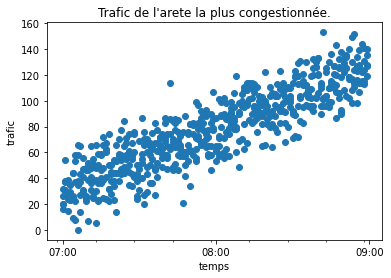

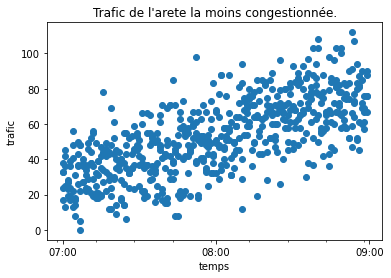

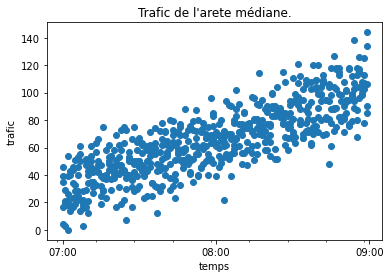

In [12]:
arete_mediane = vehicules_par_arete[249]["_id"]
arete_max, arete_min = vehicules_par_arete[0]["_id"], vehicules_par_arete[-1]["_id"]
vehicules_arete_mediane = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_mediane}}},
    {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                          "minutes":{"$minute":"$date"}},
                "nb_vehicules":1}},
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
     {"$sort":{"temps":1}}])



vehicules_arete_max = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_max}}},
    {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                          "minutes":{"$minute":"$date"}},
                "nb_vehicules":1}},
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
     {"$sort":{"temps":1}}])
vehicules_arete_min = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_min}}},
    {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                          "minutes":{"$minute":"$date"}},
                "nb_vehicules":1}},
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}},
     {"$sort":{"temps":1}}])



# Traitements relatif a l'arete la plus congestionnée
xs = pd.date_range("2020-01-01 07:00", "2020-01-01 08:59", freq = "min").to_pydatetime().tolist()
print(len(xs))
xs = [e for sub in zip(xs, xs, xs, xs, xs) for e in sub] 
# Données de trafic pour l'arete la plus congestionnée
trafics = [trafic["nb_vehicules"] for trafic in vehicules_arete_max]
# Données matinales
ys = trafics
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title="Trafic de l'arete la plus congestionnée.", xlabel="temps", ylabel="trafic")
ax.plot(xs,ys,"o")




# Traitements relatif a l'arete la moins congestionnée
trafics = [trafic["nb_vehicules"] for trafic in vehicules_arete_min]
# Données matinales
ys = trafics

fig, ax = plt.subplots()
# Affichage relatif a l'arete la moins congestionnée
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title="Trafic de l'arete la moins congestionnée.", xlabel="temps", ylabel="trafic")
ax.plot(xs,ys,"o")
# Traitements relatif a l'arete médiane
trafics = [trafic["nb_vehicules"] for trafic in vehicules_arete_mediane]
# Données matinales
ys = trafics
fig, ax = plt.subplots()
# Affichage relatif a l'arete médiane
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title="Trafic de l'arete médiane.", xlabel="temps", ylabel="trafic")
ax.plot(xs,ys,"o")
plt.show()

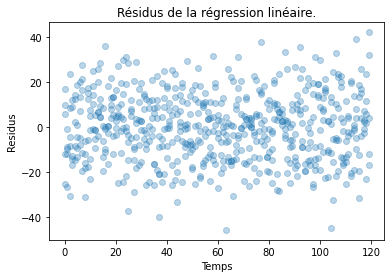

In [13]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import pylab as py

# En premier lieu le modèle devra etre entrainé avant de l'évaluer
# Les données au format date sont converties en minutes
X = [(date.hour-7)*60+date.minute for date in xs]

# Ajout de la colonne correspondant à la constante
X = X = np.append(arr = np.ones((len(X), 1)).astype(int), values = np.array([X]).T, axis = 1)
# Entrainement du modèle
regressor_OLS = sm.OLS(endog = ys, exog = X).fit()
# Predictions avec le modèle
y_pred = y_pred = regressor_OLS.params[0]+regressor_OLS.params[1]*X[:,1]

# Affichage des résidus
fig, ax = plt.subplots()
ax.scatter(X[:,1], #Les résidus
           regressor_OLS.resid, alpha=0.3)
ax.set(title="Résidus de la régression linéaire.", xlabel="Temps", ylabel="Residus")
plt.show()

In [14]:
print("Test d'homogeneite (H0 : La variance des residus est homogène)")
print('p valeur de Goldfeld–Quandt test est: ',
      sms.het_goldfeldquandt(ys, regressor_OLS.model.exog)[1])
print('p valeur of Breusch–Pagan test est: ',
      sms.het_breuschpagan(regressor_OLS.resid, regressor_OLS.model.exog)[1])
print('p valeur de White test est: ',
      sms.het_white(regressor_OLS.resid**2, regressor_OLS.model.exog)[1])


Test d'homogeneite (H0 : La variance des residus est homogène)
p valeur de Goldfeld–Quandt test est:  0.18810980328669794
p valeur of Breusch–Pagan test est:  0.13621795562102595
p valeur de White test est:  0.11981014748328286


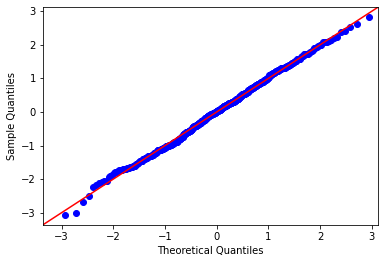

In [15]:
from scipy import stats
import pylab as py

sm.qqplot(regressor_OLS.resid_pearson, line ='45') 
py.show()

In [16]:
print("Test de normalite (H0 : les donnes suivent une loi Normale)")
print('p valeur de Jarque-Bera test est: ', stats.jarque_bera(regressor_OLS.resid)[1])
print('p value de Shapiro-Wilk test est: ', stats.shapiro(regressor_OLS.resid)[1])

Test de normalite (H0 : les donnes suivent une loi Normale)
p valeur de Jarque-Bera test est:  0.35672349931789715
p value de Shapiro-Wilk test est:  0.404720664024353


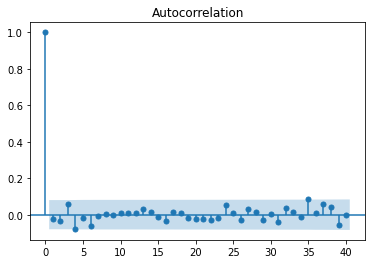

Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)
      lb_stat  lb_pvalue
1    0.365364   0.545542
2    1.005714   0.604800
3    3.014939   0.389328
4    6.556686   0.161254
5    6.782608   0.237317
6    8.928486   0.177640
7    8.988104   0.253511
8    8.990581   0.343091
9    8.990627   0.438140
10   9.053470   0.527037
11   9.090241   0.613563
12   9.152857   0.689822
13   9.826700   0.708041
14   9.975007   0.764008
15  10.042768   0.817041
16  10.892515   0.816071
17  10.994031   0.856874
18  11.055094   0.892004
19  11.261813   0.914717
20  11.633538   0.928112
21  12.045166   0.938390
22  12.549544   0.944969
23  12.754071   0.957123
24  14.354028   0.938246
25  14.395301   0.954397
26  14.883977   0.959419
27  15.490605   0.961974
28  15.658309   0.970614
29  16.281944   0.972195
30  16.305512   0.980006
31  17.445582   0.976003
32  18.338036   0.974491
33  18.483674   0.980381
34  18.626488   0.985030
35  23.344352   0.933827
36  23.393606   0.947930
37  25.493

D:\serpent\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "


In [17]:
from statsmodels.graphics import tsaplots
# Affichage de la fonction d'autocorrelation
fig = tsaplots.plot_acf(regressor_OLS.resid, lags=40)
plt.show()

print("Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)")
print(sm.stats.acorr_ljungbox(regressor_OLS.resid, return_df=True))


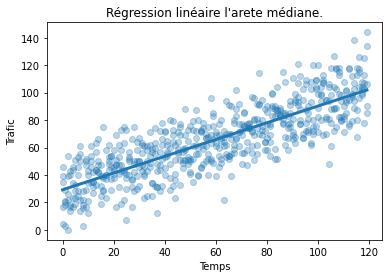

In [18]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

fig, ax = plt.subplots()
# Affichage du nuage de point
ax.scatter(X[:,1], ys, alpha=0.3)
ax.set(title="Régression linéaire l'arete médiane.", xlabel="Temps", ylabel="Trafic")
# Affichage du nuage de point
ax.plot(X[:,1], y_pred, linewidth=3)
plt.show()

In [19]:
print("Evaluation de la regression lineaire en utilisant la classe statsmodels :")
print("Les parametres de la regression sont ", 
regressor_OLS.params)
print("La valeur du R2 est ", 
regressor_OLS.rsquared)
print("Les test de Fischer sur la qualite globale de la regression ")
print("f_value ", 
regressor_OLS.fvalue,
      " f_pvalue",
regressor_OLS.f_pvalue)
print("Le resultat des t-tests ")
print("p valeurs ", 
regressor_OLS.pvalues,
      " t valeurs ", 
regressor_OLS.tvalues)

print("\nEvaluation de la regression en utilisant les formules : ")
# Calcul manuel des paramètres de la regression
slope = np.sum(np.multiply(X[:,1] - np.mean(X[:,1]),
                           ys - np.mean(ys)))/np.sum((X[:,1] - np.mean(X[:,1]))**2)
intercept = np.mean(ys)-slope*np.mean(X[:,1])
print("Terme constant et pente ", intercept, slope)

# Calcul de la statistique de fischer pour evaluer la regression
n_obs, k = len(X[:,1]), 1
# somme des ecarts expliques
sce = np.sum((y_pred-np.mean(ys))**2)
# sommes des ecarts totaux
sct = np.sum((ys-np.mean(ys))**2)
# somme des ecarts residuels
scr = sct-sce
F = (sce/k)/(scr/(n_obs-k-1))
print("Le coefficient de R2 ", sce/sct)
print("Valeur du F-test ", F)

se_x = np.sum((X[:,1] - np.mean(X[:,1]))**2)
temp = (1/n_obs + np.mean(X[:,1])**2 / se_x)
ecart_type0 = np.sqrt((scr/(n_obs-k-1)) * temp)
t0 = intercept/ecart_type0
print("Valeur de t0 ", t0)

ecart_type1 = np.sqrt(
    (scr/(n_obs-k-1)) / se_x)
t1 = slope/ecart_type1
print("Valeur du t1 ", t1)

Evaluation de la regression lineaire en utilisant la classe statsmodels :
Les parametres de la regression sont  [29.21672176  0.61111952]
La valeur du R2 est  0.6689124952053679
Les test de Fischer sur la qualite globale de la regression 
f_value  1208.1690379131921  f_pvalue 1.1568050617159316e-145
Le resultat des t-tests 
p valeurs  [2.21187780e-090 1.15680506e-145]  t valeurs  [24.1363932  34.75872607]

Evaluation de la regression en utilisant les formules : 
Terme constant et pente  29.216721763085403 0.6111195221890409
Le coefficient de R2  0.6689124952053678
Valeur du F-test  1208.1690379131912
Valeur de t0  24.136393195709385
Valeur du t1  34.75872606861752


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Nombre d'aretes dans la ville
nb_aretes = 500
# Nombre de modèles
nb_regression_models = 250
# Nombre d'aretes pris en charge par chaque modèle
nb_aretes_per_model = nb_aretes/ nb_regression_models
# Les modèles de regression
regression_models = [None]*nb_regression_models
for i in range(nb_regression_models):
    #print(i)
    num_premiere_arete, num_derniere_arete = i*nb_aretes_per_model, (i+1)*nb_aretes_per_model-1 
    # Lecture des données du trafic matinales sur les aretes dans l'intervalle
    # [num_premiere_arete, num_derniere_arete]
    X = list(db.vehicules_stamped.aggregate([
        {"$match":{"num_arete":{"$gte":num_premiere_arete, "$lte":num_derniere_arete}}},
        {"$project":{"temps":{"heures":{"$hour":"$date"}, 
                              "minutes":{"$minute":"$date"}},
                    "nb_vehicules":1,"num_arete":1}},
        {"$match":{"temps.heures":{"$lte":9, "$gte":7}}}]))
    # Conversion en minutes des données de trafic
    X = [[trafic["num_arete"],
                60*(trafic["temps"]["heures"]-7)+trafic["temps"]["minutes"], 
                trafic["nb_vehicules"]] for trafic in X]
    # Transformation de la colone "num_arete" en colonne binaire associée à chaque arete
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], 
                           remainder="passthrough")
    X = ct.fit_transform(X)
    if isinstance(X, np.ndarray) is False:
        X = X.toarray()
    else :
        X = np.array(X, dtype = int)
   # Vecteur du trafic réel par arete et par minute
    ys = X[:,-1]
    # Matrice contenant l'échantillon des données, les colonnes sont la minute et l'arete
    X = X[:, 1:-1]
    
    # Ajout de la constante dans la matrice
    X = np.append(arr = np.ones((X.shape[0], 1)), values = X, axis = 1)
    # Entrainement du modèle
    regression_models[i] = sm.OLS(endog = ys, exog = X).fit()
# seuil des tests
seuil = 0.05
# nombre de variables par modèle
nb_regressors = int(nb_aretes_per_model+1)
# Compteur du nombre de t-tests concluant de l'effet des variables par modèle
cpts_ts = [[0]*nb_regressors for i in range(nb_regression_models)]
# Compteur du nombre de F-tests conclusifs sur les modèles
cpts_f = [0]*nb_regression_models
for i in range(nb_regression_models):
    # Les p-valeurs des t-tests
    pvalues_t_test = regression_models[i].pvalues
    # Les p-valeurs des F-tests
    pvalue_f_test = regression_models[i].f_pvalue
    for j in range(len(pvalues_t_test)):
        if pvalues_t_test[j] < seuil:
            cpts_ts[i][j] += 1
            #print("p-valeur associee a la variable "+str(j)+" est "+str(pvalues_t_test [j]))
    if pvalue_f_test < seuil:
        cpts_f[i] += 1
        #print("p-valeur du f-test est "+str(pvalue_f_test))
print("Proportion de succes associee aux t-tests ", 
      [sum(
              [cpts_ts[i][j] for i in range(nb_regression_models)]
          )/nb_regression_models for j in range(nb_regressors)])
print("Proportion de succes associee aux f-tests ", sum(cpts_f)/nb_regression_models)
print("Tous les tests sont completees.")

Proportion de succes associee aux t-tests  [1.0, 0.872, 1.0]
Proportion de succes associee aux f-tests  1.0
Tous les tests sont completees.


On constate que les tests sont validés pour les différentes arêtes ce qui nous permet d'utiliser ces résultats pour effectuer des prédictions

## 4. Algorithme pour résoudre le problème

### Utilisation de l'algorithme de fourmis avec la contrainte de fenêtre de temps de livraison

#### Explication de la fonction pour lancer l'algortihme

<pre><code>
def AntColony(distance, n_ants, n_citys, iteration, alpha, beta, delivery_window)
==> AntColony(matrice_num_arete, 10, 10, 100, 1, 1, delivery_window)
</code></pre>

   * distance : Données de la matrice.
   * n_ants : Nombre de fourmis qui vont faire un chemin et poser des phéromones à chaque itération.
   * n_citys : Nombre de ville.
   * iteration : Nombre d'itération de l'algorithme.
   * alpha : Exposant sur la phéromone, si alpha est élévé alors cela donne plus de poids à la phéromone.
   * beta : Exposant sur la distance, si beta est élévé alors cela donne plus de poids sur la distance.
   * delivery_window : Fenêtre de livraison

<br>

<p>Le code ci-dessous est l'implémantation de l'algorithme des colonies de fourmis avec la contrainte de fenêtre de temps de livraison pour le problème du voyageur de commerce.</p>

In [57]:
import warnings
import numpy as np
from numpy import inf
warnings.filterwarnings("ignore")

def AntColony(distance, n_ants, n_citys, iteration, alpha, beta, delivery_window):
    
    m = n_ants
    n = n_citys
    e = 0.5         #Taux d'évaporation
     
    #intialiser le phéromone présent sur les chemins des villes

    pheromne = 0.1*np.ones((m,n))

    #intialiser la route des fourmis avec la taille route(n_ants,n_citys+1) 
    #Ajouter 1 car nous voulons revenir à la ville source

    route = np.ones((m,n+1))
    best_route = []
    cost = []
    for ite in range(iteration):
        
        index_delivery = 0
        total_delivery = len(delivery_window)
        delivery = delivery_window[index_delivery]
        total_time = len(delivery)
        current_hour, current_minutes = currentTime(delivery[0])
        route[:,0] = 1      #Position initiale de départ et d'arrivée de chaque fourmi, ville n°1
        
        dist_cost = np.zeros((m,1))      
        
        for i in range(m):
            dist_cost[i] = 0

            time = 0
            matrice = distance.copy()   #Notre matrice originale ne doit pas être modifiée
            current_matrice = graphe(matrice, current_minutes, current_hour)
            #calcul de la visibilité de la prochaine ville visibilité(i,j)=1/d(i,j)
            visibility = 1/current_matrice
            visibility[visibility == inf ] = 0 #Si inf est dans le tableau, remplacé par 0
            temp_visibility = np.array(visibility)         #créer une copie de la visibilité
            for j in range(n-1):
                #print(route)
                valid = False
                while(valid == False): #Au vu de la contrainte, il est possible que la ville choisie ne soit pas gardée
                    combine_feature = np.zeros(10)     #initialisation du tableau des caractéristiques de la combinaison à zéro
                    cum_prob = np.zeros(10)            #intialisation du tableau de probabilité cumulée à zéro

                    cur_loc = int(route[i,j]-1)        #La ville actuelle de la fourmi
                    temp_visibility[:,cur_loc] = 0     #rendre la visibilité de la ville actuelle égale à zéro
                    matrice[:,cur_loc] = 0             
                    p_feature = np.power(pheromne[cur_loc,:],beta)         #calcul de la caractéristique de phéromne 
                    v_feature = np.power(temp_visibility[cur_loc,:],alpha)  #Calcul de la caractéristique de visibilité
                
                    p_feature = p_feature[:,np.newaxis]                     #Ajout d'axe pour faire une taille de current_matrice 
                    v_feature = v_feature[:,np.newaxis]                     #Ajout d'axe pour faire une taille de current_matrice 

                    combine_feature = np.multiply(p_feature,v_feature)     #Calcul de toutes les features

                    total = np.sum(combine_feature)                        #Somme de toutes les caractéristiques
                    
                    probs = combine_feature/total   # probabilité de trouver l'élément probs(i) = comine_feature(i)/total
                    
                    cum_prob = np.cumsum(probs)     #calcul de la somme cumulée
                    
                    
                    r = np.random.random_sample()   #randon no in [0,1]
                    #print(r)
                    city = np.nonzero(cum_prob>r)[0][0]+1       #trouver la prochaine ville ayant une probabilité supérieure à random(r)
                 

                    if (time + current_matrice[int(route[i,j])-1, int(city)-1] > total_time): #Vérifier si on sort de la fenêtre de livraison

                        if (index_delivery + 1 == total_delivery):
                            index_delivery = 0
                        else:
                            index_delivery += 1
                        delivery = delivery_window[index_delivery]
                        total_time = len(delivery)
                        current_hour, current_minutes = currentTime(delivery[0])
                        time=0
                        valid=False
                    else:                                                                 #Si non, on récupère la ville ainsi que son poids
                        time += current_matrice[int(route[i,j])-1, int(city)-1]
                        dist_cost[i] += current_matrice[int(route[i,j])-1, int(city)-1]
                        current_hour, current_minutes = currentTime(delivery[int(time)])
                        route[i,j+1] = city  #Ajouter une ville à l'itinéraire 
                        valid=True
                    current_matrice = graphe(distance, current_minutes, current_hour)     #Enfin, on ré-affecte nos matrices et nos variables avec le nouveau temps
                    current_visibility = graphe(matrice, current_minutes, current_hour)
                    temp_visibility = 1/current_visibility
                    temp_visibility[temp_visibility == inf ] = 0
                    
            dist_cost[i] += current_matrice[int(city)-1, int(route[i,-1])-1] #Trouver le poids pour revenir à la position initiale
            
        route_opt = np.array(route)               #intialisation de la route optimale
 
        
        dist_min_loc = np.argmin(dist_cost)             #trouver l'emplacement du minimum de dist_cost
        dist_min_cost = dist_cost[dist_min_loc]         #trouver le minimum de dist_cost
        #print(dist_min_loc)
        cost.append(dist_min_cost)
        best_route.append(route[dist_min_loc,:])               #intialisation du trajet actuel comme meilleur itinéraire
        #print(best_route)  
        pheromne = (1-e)*pheromne                       #évaporation de la phéromne avec (1-e)
        for i in range(m):
            for j in range(n-1):
                dt = 1/dist_cost[i]
                pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] = pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] + dt   
    
 
    dist_min_loc = np.argmin(cost)             #trouver l'emplacement du minimum de dist_cost
    dist_min_cost = cost[dist_min_loc]         #trouver le minimum de dist_cost

    print('best path :', best_route[dist_min_loc])
    print("coût",dist_min_cost)           

In [23]:
#Création de nos fenêtres de livraison
xs = pd.date_range("2020-01-01 07:00", "2020-01-01 08:59", freq = "min").to_pydatetime().tolist()
delivery_window = []
delivery_window.append(xs)
xs = pd.date_range("2020-01-01 10:00", "2020-01-01 11:59", freq = "min").to_pydatetime().tolist()
delivery_window.append(xs)
xs = pd.date_range("2020-01-01 17:00", "2020-01-01 18:59", freq = "min").to_pydatetime().tolist()
delivery_window.append(xs)

<p> Maintenant nous éxecutons l'algorithme de colonies de fourmis poiur connaitre le meilleur chemin:

In [24]:
AntColony(matrice_num_arete, 10, 10, 100, 1, 1, delivery_window)

best path : [ 1.  6. 10.  3.  9.  5.  7.  8.  4.  2.  1.]
coût [199.71014251]


## 5.Etude expérimentale

### A.Calcul des bornes inférieures


Nous utilisons la première version de notre algorithme ainsi que notre première génération de données. La raison est que pour nos bornes inférieures, nous n'avons pas la contrainte du trafic et donc, pas la contrainte de fenêtre de livraison.

In [25]:
import numpy as np
import json
import os
taille_max = 15
def grapheAleatoire(taille_max, valeur_max):
    data= []
    
    matrice = np.ones((taille_max,taille_max))

    #Récupération des graphes présents dans le fichier
    fileName = r"graph.json"
    if os.path.isfile(fileName):
        with open('graph.json', 'r') as fp:
            data = json.load(fp)
    #Ajout des poids dans la matrice en fonction du début de la fenêtre de livraison
    for ligne in range(taille_max):
        if (matrice[ligne][ligne]):
            matrice[ligne][ligne] = 0
        for sommet in range(taille_max):            
            if (matrice[ligne][sommet]):
                
                poids = np.random.randint(1,valeur_max)
                
                matrice[ligne][sommet] = poids
                matrice[sommet][ligne] = matrice[ligne][sommet]
    data.append(matrice.tolist())
    #Remplissage du fichier avec le nouveau graphe
    with open('graph.json', 'w') as fp:
        json.dump(data, fp)
    return matrice




plage_horaire = {'3h-9h': 85/100, '9h-15h': -25/100, '15h-21h': 30/100,'21h-3h':-50/100} #Tableau avec nos prévisions de trafics

matrice = grapheAleatoire(taille_max, 15)


In [54]:
import warnings
import numpy as np
from numpy import inf
warnings.filterwarnings("ignore")

def FirstAntColony(distance, n_ants, n_citys, iteration, alpha, beta):
    """
        Args:
            distances (numpy.array): Matrice carrée des distances.
            n_ants (int): Nombre de fourmis par itération
            n_iteration (int): Nombre d'itérations
            alpha (int or float): exposant sur la phéromone, un alpha plus élevé donne plus de poids à la phéromone.
            beta (int or float): exposant sur la distance, un bêta plus élevé donne plus de poids à la distance
        Example:
            AntColony(matrice_cur, 10, 10, 100, 8, 8)       
    """
    #Taux d'évaporation
    #Le facteur phéromonal
    #Facteur de visibilité
    
    # partie d'initialisation

    m = n_ants
    n = n_citys
    e = 0.5         #Taux d'évaporation
    
    #calcul de la visibilité de la prochaine ville visibilité(i,j)=1/d(i,j)

    visibility = 1/distance

    visibility[visibility == inf ] = 0 #Si inf est dans le tableau, remplacé par 0
    #print(visibility)

    #intialiser le phéromone présent sur les chemins des villes

    pheromne = 0.1*np.ones((m,n))

    #intialiser la route des fourmis avec la taille route(n_ants,n_citys+1) 
    #Ajouter 1 car nous voulons revenir à la ville source
    best_route = []
    cost = []
    route = np.ones((m,n+1))

    for ite in range(iteration):

        route[:,0] = 1      #Position initiale de départ et d'arrivée de chaque fourmi, ville n°1

        for i in range(m):

            temp_visibility = np.array(visibility)         #créer une copie de la visibilité

            for j in range(n-1):
                #print(route)

                combine_feature = np.zeros(10)     #initialisation du tableau des caractéristiques de la combinaison à zéro
                cum_prob = np.zeros(10)            #intialisation du tableau de probabilité cumulée à zéro

                cur_loc = int(route[i,j]-1)        #La ville actuelle de la fourmi
                #print(cur_loc)
                temp_visibility[:,cur_loc] = 0     #rendre la visibilité de la ville actuelle égale à zéro

                p_feature = np.power(pheromne[cur_loc,:],beta)         #calcul de la caractéristique de phéromne 
                v_feature = np.power(temp_visibility[cur_loc,:],alpha)  #Calcul de la caractéristique de visibilité

                p_feature = p_feature[:,np.newaxis]                     #Ajout d'axe pour faire une taille de matrice_cur (10)
                #print(p_feature)
                v_feature = v_feature[:,np.newaxis]                     #Ajout d'axe pour faire une taille de matrice_cur (10)
                #print(v_feature)

                combine_feature = np.multiply(p_feature,v_feature)     #Calcul de toutes les features

                total = np.sum(combine_feature)                        #Somme de toutes les caractéristiques
                #print(total)
                probs = combine_feature/total   # probabilité de trouver l'élément probs(i) = comine_feature(i)/total
                #print(probs)
                cum_prob = np.cumsum(probs)     #calcul de la somme cumulée
                #print(cum_prob)
                r = np.random.random_sample()   #randon no in [0,1]
                #print(r)
                city = np.nonzero(cum_prob>r)[0][0]+1       #trouver la prochaine ville ayant une probabilité supérieure à random(r)


                route[i,j+1] = city              #Ajouter une ville à l'itinéraire #adding city to route 

            left = list(set([i for i in range(1,n+1)])-set(route[i,:-2]))[0]     #trouver la dernière ville non traversée pour la route

            route[i,-2] = left                   #Ajout d'une ville non traversée à l'itinéraire

        route_opt = np.array(route)               #intialisation de la route optimale
        #print(dist_cost)
        dist_cost = np.zeros((m,1))             #intialisation de la distance totale du tour avec zéro 

        for i in range(m):

            s = 0
            for j in range(n-1):

                s = s + distance[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1]   #calcul de la distance totale du tour
                #print(s)
            s += distance[int(route_opt[i,-2])-1,0]
            dist_cost[i]=s                      # Stocker la distance de la tournée de la 'i' fourmi à l'emplacement 'i'. 
            #print(s)

        dist_min_loc = np.argmin(dist_cost)             #trouver l'emplacement du minimum de dist_cost
        dist_min_cost = dist_cost[dist_min_loc]         #trouver le minimum de dist_cost
        #print(dist_min_loc)
        cost.append(dist_min_cost)
        best_route.append(route[dist_min_loc,:])               #intialisation du trajet actuel comme meilleur itinéraire
        #print(best_route)
        pheromne = (1-e)*pheromne                       #évaporation de la phéromne avec (1-e)
        for i in range(m):
            for j in range(n-1):
                dt = 1/dist_cost[i]
                pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] = pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] + dt   
    
    #print('route of all the ants at the end :')
    #print(route_opt)

    dist_min_loc = np.argmin(cost)             #trouver l'emplacement du minimum de dist_cost
    dist_min_cost = cost[dist_min_loc]         #trouver le minimum de dist_cost
    print('best path :', best_route[dist_min_loc])
    print("coût",dist_min_cost)                    

In [27]:
from pulp import *
problem =LpProblem('tsp_mip', LpMinimize)

# set valiables
x = LpVariable.dicts('x', ((i, j) for i in range(taille_max) for j in range(taille_max)), lowBound=0, upBound=1, cat='Binary')
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = LpVariable.dicts('u', (i for i in range(taille_max)), lowBound=1, upBound=taille_max, cat='Integer')

# set objective function
problem += lpSum(matrice[i][j] * x[i, j] for i in range(taille_max) for j in range(taille_max))

# set constrains
for i in range(taille_max):
    problem += x[i, i] == 0

for i in range(taille_max):
    problem += lpSum(x[i, j] for j in range(taille_max)) == 1
    problem += lpSum(x[j, i] for j in range(taille_max)) == 1

# eliminate subtour
for i in range(taille_max):
    for j in range(taille_max):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= taille_max * (1 - x[i, j]) - 1
            
# solve problem
status = problem.solve()

print(status, LpStatus[status], value(problem.objective))

1 Optimal 36.0


In [28]:
FirstAntColony(matrice, taille_max, taille_max, 100, 1, 1)

best path : [ 1. 13.  4.  6.  5.  8. 11.  7. 15. 10.  9. 12. 14.  3.  2.  1.]
coût [40.]


Nous pouvons donc comparer le résultat obtenu avec l'algorithme et le résultat de la borne inférieure. On peut donc considérer que l'algorithme est optimal malgré que notre réel code comprend le trafic prédictif ainsi que les fenêtres de livraison.

### B.Statistiques et tests

Nous cherchons à faire des tests et des statistiques pour comprendre le comportement de notre algorithme.

#### Expérimentations sur la taille du graphe

10
best path : [ 1. 10.  2.  8.  5.  9.  7.  6.  4.  3.  1.]
coût [201.86799205]
15
best path : [ 1. 10.  4.  6. 15.  3.  2. 14.  8.  7. 12. 13.  5. 11.  9.  1.]
coût [312.41254983]
20
best path : [ 1.  5.  4. 12. 13.  9.  3. 18.  6.  2. 16. 20.  8. 11.  7. 14. 19. 10.
 15. 17.  1.]
coût [400.28633367]
25
best path : [ 1. 10.  4. 16. 19. 15.  2.  9.  6. 24. 20.  7. 25. 14.  5. 13. 23. 22.
 18. 21. 12.  8. 17. 11.  3.  1.]
coût [561.14112643]
30
best path : [ 1. 22. 15.  8. 18. 29. 30. 25.  5.  4. 23. 27. 12. 28. 13. 26. 20. 16.
  7. 21. 14.  2.  6. 19. 24.  9. 10.  3. 11. 17.  1.]
coût [639.91728676]
35
best path : [ 1. 35. 11. 18. 21. 34. 24. 13. 32. 19.  4. 26. 20. 22. 14. 33. 31. 23.
 28.  9. 29. 15.  8.  6. 17.  2.  7. 10. 12.  3. 27. 25.  5. 16. 30.  1.]
coût [758.84629565]
40
best path : [ 1. 33. 19. 24. 11.  2. 27. 39. 40. 17. 18. 23. 20. 26. 16.  4. 32.  3.
  7. 28. 12. 35. 13.  8.  9. 29. 22. 31. 30. 15.  5. 38. 14. 10. 25. 37.
  6. 36. 34. 21.  1.]
coût [888.2016906]
45
best 

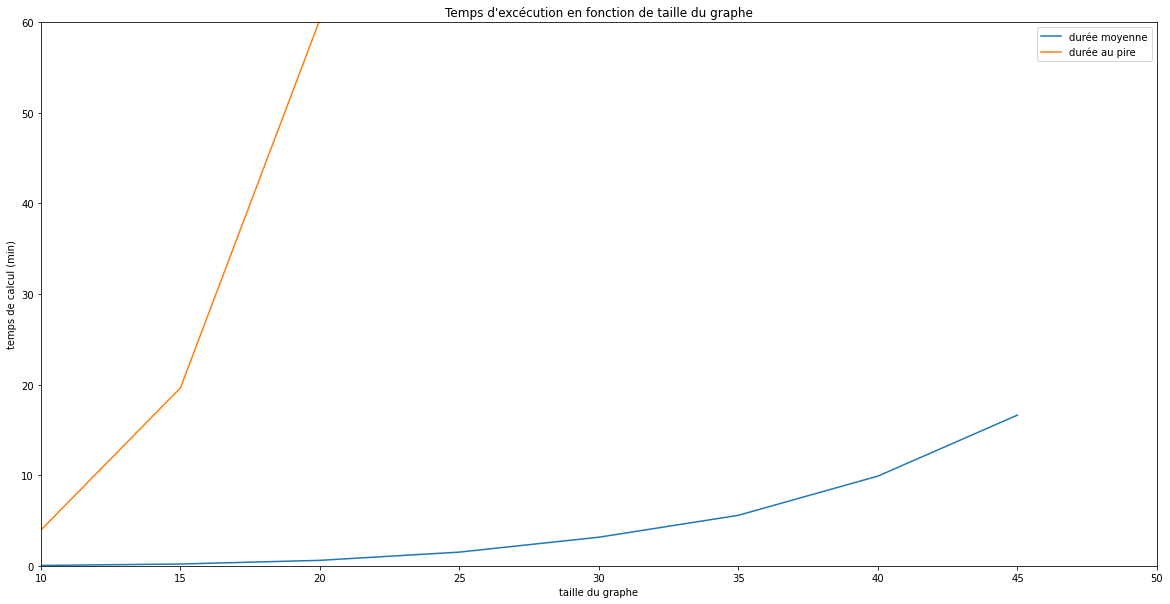

In [34]:
import time
from matplotlib import pyplot as plt

#number of cities 
durees_moy = list()
durees_pire = list()
nb_iteration = 100
cities_number = list()

for taille in range(10, 50, 5):
    instance = grapheAleatoireArete(taille)
    duree_pire = 0
    duree_moy = 0
    print(taille)
    start = time.process_time()
    AntColony(instance, taille, taille, nb_iteration, 5, 5, delivery_window)
    stop = time.process_time()
    duree = (stop-start)
    
    if duree_pire < duree:
        duree_pire = duree
    
    duree_moy += duree
    durees_moy.append(duree_moy/nb_iteration)
    durees_pire.append(duree_pire)
    cities_number.append(taille)

plt.figure(figsize=(20,10))
plt.ylim([0, 60])
plt.xlim([10, 50])
plt.xlabel('taille du graphe')
plt.ylabel('temps de calcul (min)')
plt.plot(cities_number, durees_moy, label='durée moyenne')
plt.plot(cities_number, durees_pire, label='durée au pire')
plt.title("Temps d'excécution en fonction de taille du graphe")
plt.legend()
plt.show()

#### Expérimentation sur le nombre d'itération 

1
51
101
151
201
251


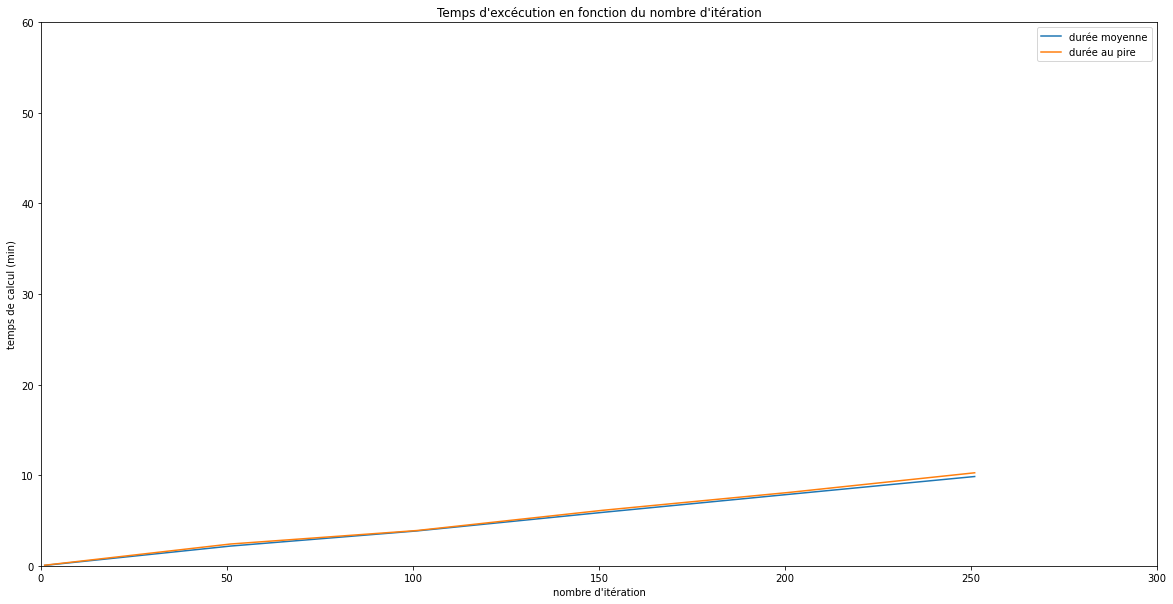

In [56]:
import time
from matplotlib import pyplot as plt

#number of iteration
durees_moy = list()
durees_pire = list()
taille = 10
nb_iteration_list = list()

for nb_iteration in range(1, 300, 50):
    instance = grapheAleatoireArete(taille)
    nb_test = 10
    duree_pire = 0
    duree_moy = 0  
    print(nb_iteration)
    for i in range (nb_test):
        start = time.process_time()
        AntColony(instance, taille, taille, nb_iteration, 5, 5, delivery_window)
        stop = time.process_time()
        duree = (stop-start)

        if duree_pire < duree:
            duree_pire = duree
    
        duree_moy += duree
    

    durees_moy.append(duree_moy/nb_test)
    durees_pire.append(duree_pire)
    nb_iteration_list.append(nb_iteration)

plt.figure(figsize=(20,10))
plt.xlim([0, 300])
plt.ylim([0, 60])
plt.xlabel("nombre d'itération")
plt.ylabel("temps de calcul (min)")
plt.plot(nb_iteration_list, durees_moy, label='durée moyenne')
plt.plot(nb_iteration_list, durees_pire, label='durée au pire')
plt.title("Temps d'excécution en fonction du nombre d'itération")
plt.legend()
plt.show()

#### Expérimentation sur l'alpha 

1
best path : [ 1. 10.  5.  2.  4.  9.  6.  7.  8.  3.  1.]
coût [200.49016828]
2
best path : [ 1.  4. 10.  5.  7.  6.  8.  3.  2.  9.  1.]
coût [197.52082586]
3
best path : [ 1.  8.  4.  9.  7.  5.  2.  6. 10.  3.  1.]
coût [200.13783801]
4
best path : [ 1.  4.  2. 10.  7.  9.  6.  5.  3.  8.  1.]
coût [188.36657261]
5
best path : [ 1.  4.  6.  3.  5.  7.  9.  2. 10.  8.  1.]
coût [202.42867453]
6
best path : [ 1.  3.  4.  6.  8.  9.  7. 10.  5.  2.  1.]
coût [195.46461101]
7
best path : [ 1.  8.  2.  5.  7.  6.  9.  3.  4. 10.  1.]
coût [186.36615265]
8
best path : [ 1.  4.  2.  9.  5. 10.  3.  8.  6.  7.  1.]
coût [200.43327078]
9
best path : [ 1.  2.  7.  4.  6. 10.  3.  8.  5.  9.  1.]
coût [192.45147871]
10
best path : [ 1.  7.  3.  4. 10.  2.  6.  5.  8.  9.  1.]
coût [202.10556278]
11
best path : [ 1.  5.  3.  9.  8. 10.  7.  6.  4.  2.  1.]
coût [200.13548795]
12
best path : [ 1.  5.  3.  9.  8. 10.  6.  2.  4.  7.  1.]
coût [187.42566324]
13
best path : [ 1.  4.  6. 10.  7.  

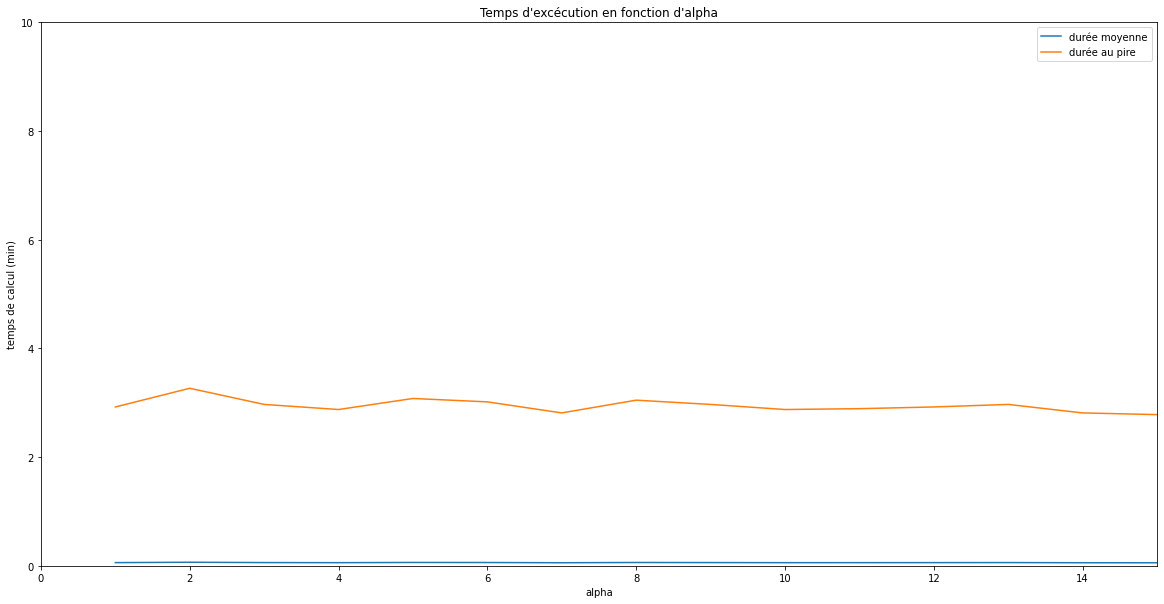

In [45]:
import time
from matplotlib import pyplot as plt

#value of 
valeur_max = 200
durees_moy = list()
durees_pire = list()
taille_max = 10
nb_iteration = 50
alpha_list = list()
for alpha in range(1, 20, 1):
    print(alpha)
    instance = grapheAleatoireArete(taille_max)
    duree_pire = 0
    duree_moy = 0
    duree_total = 0  
    start = time.process_time()
    AntColony(instance, taille_max, taille_max, nb_iteration, alpha, 1, delivery_window)
    stop = time.process_time()
    duree = (stop-start)
    if duree_pire < duree:
        duree_pire = duree
    duree_moy += duree
    duree_total += duree
    durees_moy.append(duree_moy/nb_iteration)
    durees_pire.append(duree_pire)
    alpha_list.append(alpha)

plt.figure(figsize=(20,10))
plt.xlim([0, 15])
plt.ylim([0, 10])
plt.xlabel("alpha")
plt.ylabel("temps de calcul (min)")
plt.plot(alpha_list, durees_moy, label='durée moyenne')
plt.plot(alpha_list, durees_pire, label='durée au pire')
plt.title("Temps d'excécution en fonction d'alpha")
plt.legend()
plt.show()

#### Expérimentation sur Beta

1
best path : [ 1.  2.  9.  8.  4.  7.  5.  3. 10.  6.  1.]
coût [194.40337683]
2
best path : [ 1.  8.  2. 10.  5.  4.  7.  3.  6.  9.  1.]
coût [200.5939152]
3
best path : [ 1.  5.  3.  4.  6.  2.  8.  7.  9. 10.  1.]
coût [203.70871936]
4
best path : [ 1.  3.  5.  9.  8.  7. 10.  4.  6.  2.  1.]
coût [206.37615748]
5
best path : [ 1.  9.  7.  5.  8.  2.  3. 10.  6.  4.  1.]
coût [201.15211022]
6
best path : [ 1. 10.  9.  5.  8.  3.  4.  7.  2.  6.  1.]
coût [203.39497035]
7
best path : [ 1.  5.  3.  2.  9.  7. 10.  4.  8.  6.  1.]
coût [206.12259226]
8
best path : [ 1.  6.  7.  2.  9.  3.  4. 10.  5.  8.  1.]
coût [199.75180606]
9
best path : [ 1.  5.  9.  7.  6.  2.  8.  4.  3. 10.  1.]
coût [200.415203]
10
best path : [ 1.  5.  2. 10.  3.  4.  6.  9.  7.  8.  1.]
coût [200.60872467]
11
best path : [ 1.  3. 10.  2.  4.  8.  6.  5.  9.  7.  1.]
coût [201.6917704]
12
best path : [ 1. 10.  8.  2.  6.  4.  7.  3.  9.  5.  1.]
coût [202.28821314]
13
best path : [ 1.  6.  3.  8.  2.  9.  

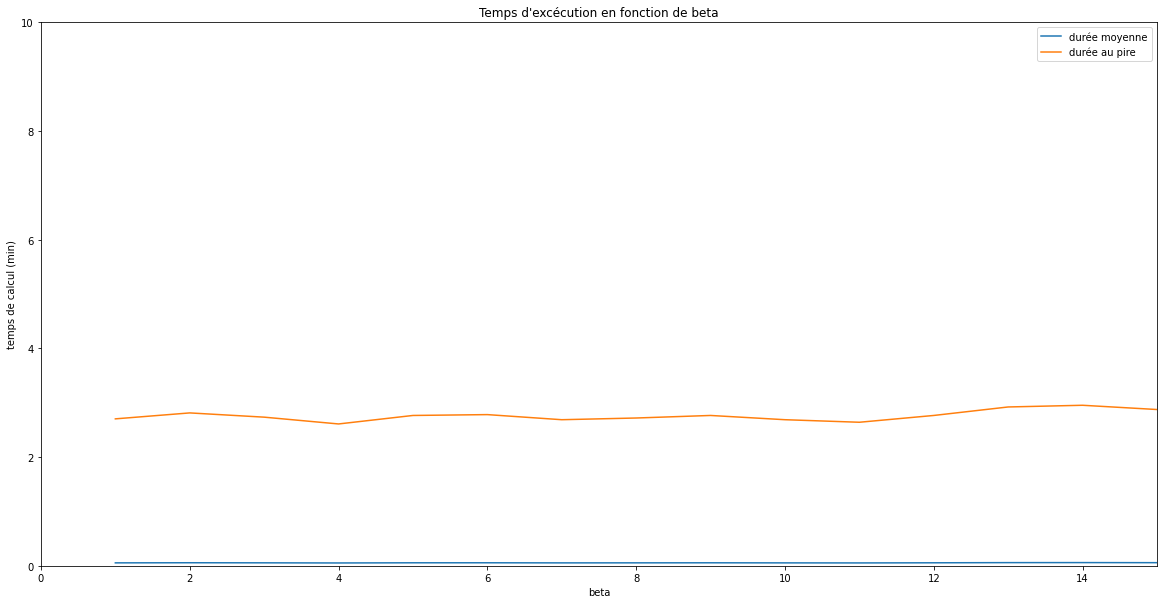

In [44]:
import time
from matplotlib import pyplot as plt

#value of 
valeur_max = 200
durees_moy = list()
durees_pire = list()
taille_max = 10
nb_iteration = 50
beta_list = list()
for beta in range(1, 20, 1):
    print(beta)
    instance = grapheAleatoireArete(taille_max)
    duree_pire = 0
    duree_moy = 0
    duree_total = 0  
    start = time.process_time()
    AntColony(instance, taille_max, taille_max, nb_iteration, 1, beta, delivery_window)
    stop = time.process_time()
    duree = (stop-start)
    if duree_pire < duree:
        duree_pire = duree
    duree_moy += duree
    duree_total += duree
    durees_moy.append(duree_moy/nb_iteration)
    durees_pire.append(duree_pire)
    beta_list.append(beta)
    
plt.figure(figsize=(20,10))
plt.xlim([0, 15])
plt.ylim([0, 10])
plt.xlabel("beta")
plt.ylabel("temps de calcul (min)")
plt.plot(beta_list, durees_moy, label='durée moyenne')
plt.plot(beta_list, durees_pire, label='durée au pire')
plt.title("Temps d'excécution en fonction de beta")
plt.legend()
plt.show()

### C. Statistiques descriptives

Pour les tests et l'analyse de l'algorithme, nous allons récupérer le temps mis par l'algorithme pour nous donner une réponse mais aussi le coût qu'il nous donne.

Pour cela, nous avons rempli un fichier excel ou se trouve les données obtenues.

Le code ci-dessous automatique l'algorithme pour tester et donc données les resultats pour remplir le fichier excel.

Nous exécutons l'algorithme 10 fois pour apouuvoir faire une bonne analyse et changeons à chaque fois les parametres pour remplir l'excel.

In [31]:
import time
i = 1
taille=10
nb_iteration = 100
n_ants=10

for _ in range(10):
    instance = grapheAleatoireArete(taille)
    start = time.time() # start time
    AntColony(instance, n_ants, taille, nb_iteration, 1, 1, delivery_window)
    end   = time.time() # end time
    total = end - start

    print("N°%s : %s" % (i, total))
    i += 1

best path : [ 1.  6.  2.  5. 10.  7.  3.  4.  8.  9.  1.]
coût [192.21130016]
N°1 : 3.7652461528778076
best path : [ 1.  4.  7.  8.  6.  9.  3.  2. 10.  5.  1.]
coût [197.65914008]
N°2 : 3.698763847351074
best path : [ 1.  3.  5.  6.  9.  2. 10.  4.  7.  8.  1.]
coût [197.84781777]
N°3 : 3.7516677379608154
best path : [ 1.  5.  6.  4.  7.  9. 10.  3.  2.  8.  1.]
coût [201.45614671]
N°4 : 3.752446413040161
best path : [ 1.  5.  3. 10.  9.  7.  2.  6.  8.  4.  1.]
coût [195.03874439]
N°5 : 3.9259870052337646
best path : [ 1.  2.  7. 10.  4.  3.  8.  9.  5.  6.  1.]
coût [201.72268751]
N°6 : 3.8065052032470703
best path : [ 1. 10.  9.  8.  3.  6.  7.  4.  5.  2.  1.]
coût [187.35421439]
N°7 : 3.7801074981689453
best path : [ 1.  8.  7.  3.  2.  4.  9. 10.  5.  6.  1.]
coût [194.22156115]
N°8 : 3.7435874938964844
best path : [ 1.  2.  6.  9.  5.  3.  7.  8.  4. 10.  1.]
coût [198.81029047]
N°9 : 3.808568239212036
best path : [ 1.  8. 10.  6.  2.  9.  4.  5.  3.  7.  1.]
coût [197.39843388



Pour cela, on récupère le temps (en s) d'exécution de l'algorithme et le coût de la solution trouvée.
Pour réaliser des statistiques descriptives, nous avons effectué des tests sur notre algorithme.

Nous changeons différetens valeurs : 

* le nombre d'itérations de 50 à 200
* le nombre de fourmis de 10 à 40

Pour chaque combinaison d'itération et de fourmi, nous avons effectué 10 tests afin d'obtenir des résultats plus intéressants.
Nous avons fait les tests sur une base de 10 villes.

Il faut donc calculer pour chaque combinaison :

* La moyenne
* Le minimum
* Le maximum
* La médiane
* La variance
* L'écart-type

Le diagramme ci-dessous est un exemple des calculs.

Sur l'axe Y : nous avons le nombre d'itérations.
Sur l'axe X le nombre de fourmis.

Au centre de la matrice, les données sont en deux parties, le temps d'exécution et le coût.

A la fin de chaque axe, nous avons donc les résultats statistiques avec les différentes données.

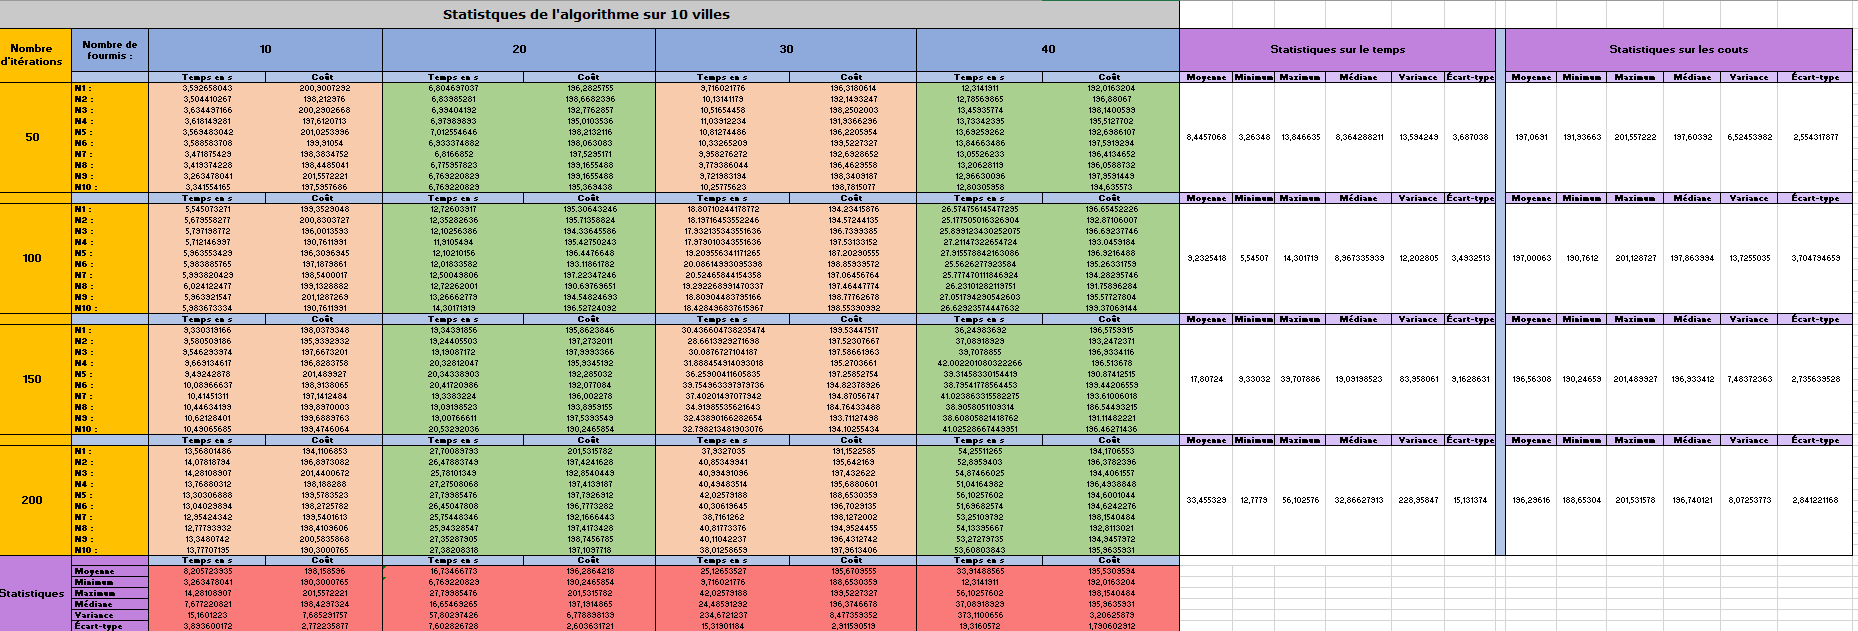



### Analyse

Nous pouvons voir qu'un plus grand nombre de fourmis donne de meilleurs résultats qu'un grand nombre d'itérations.
Le temps augmente énormément en augmentant les fourmis par rapport aux itérations.

Nous pouvons dire que si nous cherchons à avoir un résultat rapidement pour pouvoir livrer le plus rapidement possible, le plus rentable serait donc d'avoir beaucoup d'itération et peu de fourmis.

Mais si on cherche à avoir la meilleure qualité de résultat on augmente le nombre de fourmis.

## CONCLUSION

Nous essayons d'optimiser un problemes de voyageur de commerce. Pour cela, nous avons choisi d'utiliser l'algorithme des colonies de fourmis pour trouver une solution au problème TSP.

Pour cela, nous générons aléatoirement des villes.

Ensuite, nous obtenons le nombre total de voitures par bord et par jour.
Grâce à cela, nous prédisons grâce à la régression linéaire le trafic du jour suivant pour chaque bord.

Nous utilisons ensuite la programmation linéaire pour connaître la borne minimale de notre algorithme.
Nous calculons également les limites de l'algorithme. Grâce à ces limites, nous pouvons critiquer le résultat que nous obtenons.

Nous avons donc ensuite effectué l'algorithme des colonies de fourmis pour trouver une solution à notre problème TSP.
Grâce à cela, nous obtenons donc le chemin optimisé en fonction de la contrainte de fenêtre de livraison.

Puis nous finissons par tester notre algorithme et analyser les résultats obtenus.

## Amélioration

 * Afficher l'ordre de passage des villes sur la carte (de manière un peu plus graphique)
 * Optimiser l'algorithme
 * Faire plus de tests et d'analyses sur l'algorithme